In [61]:
import import_ipynb
import utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [62]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")[0]


In [63]:

def organize_in_dict(data_list):
    data_dict = {}
    for e in data_list:
        year = int(e.columns[1][:4])
        if year == 2021:
            year = 2020
        data_dict[year] = e.set_index('country')
    return data_dict

data_pop = organize_in_dict(data_pop)
data_fertility = organize_in_dict(data_fertility)
data_child = organize_in_dict(data_child)
data_capita = organize_in_dict(data_capita)
data_climat.set_index('country', inplace=True)

In [64]:
years = [y for y in range(1992, 2021, 4)]

In [65]:
X_list = []
country_names = {}

for annee in years:
    print(annee)
    concatenated_data = pd.concat(
        [ data_pop[annee],
          data_fertility[annee],
          data_child[annee],
          data_capita[annee],
          data_climat ]
        , axis=1, join='inner')

    X_list.append(concatenated_data)
    country_names[annee] = np.array(concatenated_data.index)

X = np.vstack(X_list)
print(X.shape)

1992
1996
2000
2004
2008
2012
2016
2020
(1144, 8)


In [66]:
#preparation des labels pour classification 1992-->2020 labels à 3 classes
import pandas as pd

label_class_3 = pd.read_csv("labels_class_3_class.csv")
label_class_3.set_index('year', inplace=True)

labels_list = []
for year in years:
    print(year)
    label = label_class_3.loc[year]
    labels_list.append(label[country_names[year]])

y_class_3 = np.hstack(labels_list)
y_class_3.shape


1992
1996
2000
2004
2008
2012
2016
2020


(1144,)

In [67]:
# création des label pour tous les événements 1992->2020
import pandas as pd
df_delegations = pd.read_csv("./second_part_countries_cleaned_normalized.csv")
df_delegations.set_index('year', inplace=True)

labels_list = []
for year in years:
    print(year)
    label = df_delegations.loc[year]
    labels_list.append(label[country_names[year]])

y = np.hstack(labels_list)
y.shape

1992
1996
2000
2004
2008
2012
2016
2020


(1144,)

In [68]:
import itertools

In [69]:

country_names_all = list(itertools.chain.from_iterable([country_names[year] for year in years]))

# séparation des données en train et test
X_train, X_test, y_train, y_test, country_train, country_test, cl_train, cl_test = train_test_split(
    X, y, country_names_all, y_class_3,  test_size=0.2, random_state=42)


In [70]:
print(len(cl_train[ cl_train == 0]))
print(len(cl_train[ cl_train == 1]))
print(len(cl_train[ cl_train == 2]))

795
108
12


In [71]:
#version de tensorflow
import tensorflow as tf
print(tf.__version__)


2.18.0


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.layers import BatchNormalization, Dropout

true_labels = []
predicted_labels = []
n_folds = 3
N_EP = 300

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

regression_loss_per_fold = []
classification_loss_per_fold = []
regression_mse_per_fold = []
classification_accuracy_per_fold = []


class_weights = compute_class_weight('balanced', classes=np.unique(cl_train), y=cl_train)
class_weight_array = np.array(class_weights)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold   = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold   = y_train[train_index], y_train[val_index]
    cl_train_fold, cl_val_fold = cl_train[train_index], cl_train[val_index]

    cl_train_fold_onehot = to_categorical(cl_train_fold, num_classes=3)
    cl_val_fold_onehot   = to_categorical(cl_val_fold,   num_classes=3)

    inputs = Input(shape=(X_train.shape[1],))
    first_l = Dense(50, activation='relu')(inputs)
    #first_l = BatchNormalization()(first_l)
    first_l = Dropout(0.2)(first_l)

    second_l = Dense(16, activation='relu')(first_l)
    #second_l = BatchNormalization()(second_l)
    second_l = Dropout(0.2)(second_l)
    
    regression_output = Dense(1, activation='linear', name='regression_output')(second_l)
    classification_output = Dense(3, activation='softmax', name='classification_output')(second_l)

    model = Model(inputs=inputs, outputs=[regression_output, classification_output])

    model.compile(
        optimizer='adam',
        loss=['mse', 'categorical_crossentropy'],
        metrics=["mse", "accuracy"])

    regression_sample_weight     = np.ones_like(y_train_fold)
    classification_sample_weight = class_weight_array[cl_train_fold]

    history = model.fit(
        X_train_fold,
        [y_train_fold, cl_train_fold_onehot],
        sample_weight=[regression_sample_weight, classification_sample_weight],
        epochs=N_EP,
        batch_size=16,
        validation_data=(
            X_val_fold,
            [y_val_fold,  
             cl_val_fold_onehot],
        ),
        
        verbose=1
    )

    regression_loss_per_fold.append(history.history['regression_output_loss'])
    classification_loss_per_fold.append(history.history['classification_output_loss'])
    regression_mse_per_fold.append(history.history['regression_output_mse'])
    classification_accuracy_per_fold.append(history.history['classification_output_accuracy'])


    _, classification_preds = model.predict(X_val_fold)
    predicted_classes = np.argmax(classification_preds, axis=1)
    true_labels.extend(cl_val_fold)
    predicted_labels.extend(predicted_classes)
    
    
model.summary()







Epoch 1/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - classification_output_accuracy: 0.5578 - classification_output_loss: 1.1252 - loss: 1.1625 - regression_output_loss: 0.0364 - regression_output_mse: 0.0365 - val_classification_output_accuracy: 0.4885 - val_classification_output_loss: 1.0351 - val_loss: 1.0677 - val_regression_output_loss: 0.0295 - val_regression_output_mse: 0.0307
Epoch 2/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - classification_output_accuracy: 0.4609 - classification_output_loss: 1.1357 - loss: 1.1690 - regression_output_loss: 0.0328 - regression_output_mse: 0.0328 - val_classification_output_accuracy: 0.5082 - val_classification_output_loss: 1.0123 - val_loss: 1.0443 - val_regression_output_loss: 0.0280 - val_regression_output_mse: 0.0290
Epoch 3/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - classification_output_accuracy: 0.4603 - classification_output_loss: 1.0285 - loss: 1.0603 - regression_output_loss: 0.0313 - regression_output_mse: 0.0313 - val_classifi

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 50)        │        450 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 50)        │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 16)        │        816 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 16)        │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         17 │ dropout_29[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 3)         │         51 │ dropout_29[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 1,334 (5.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,670 (10.43 KB)

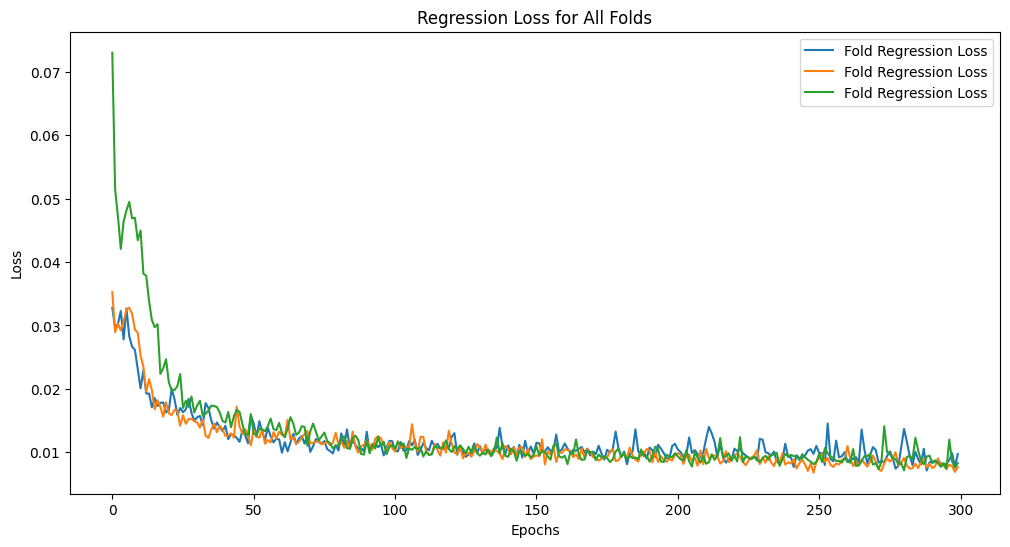

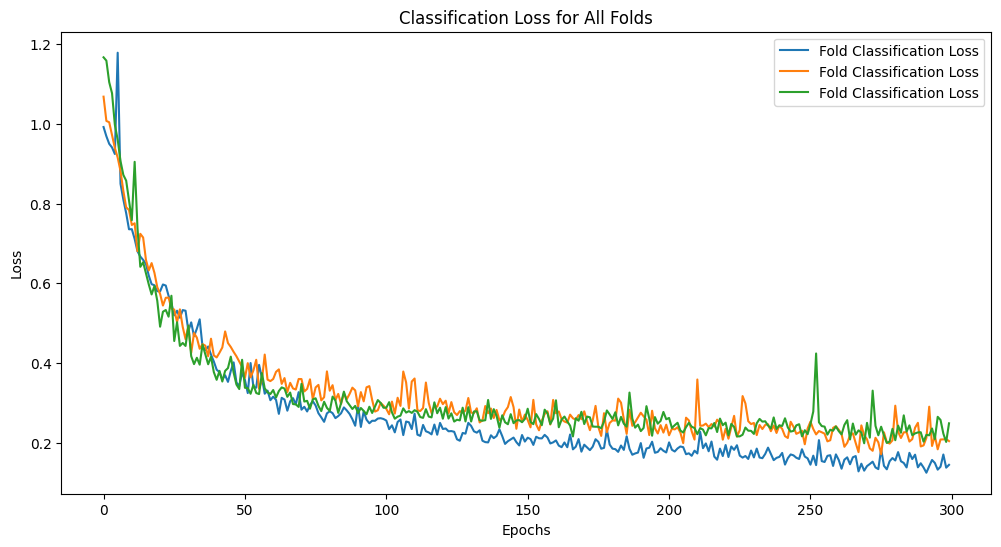

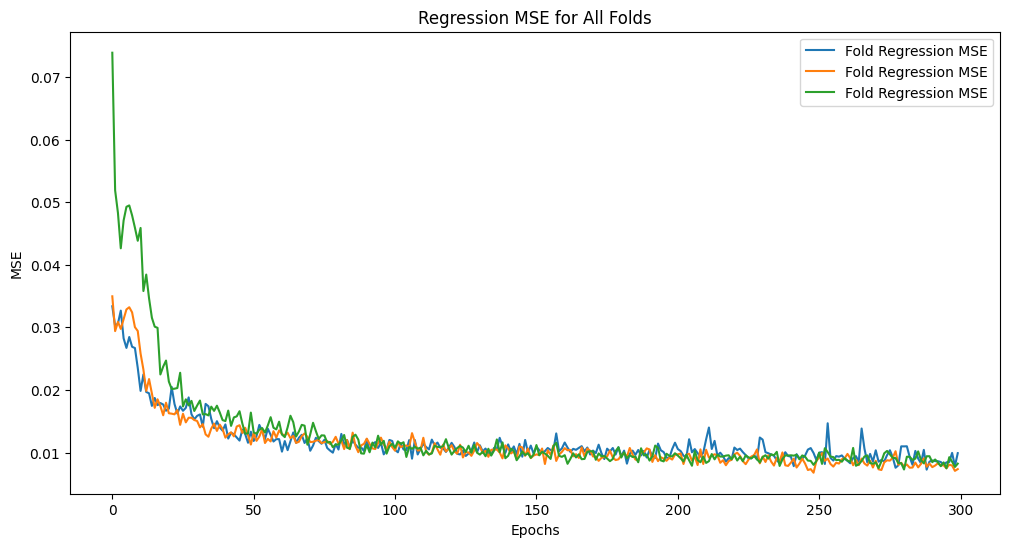

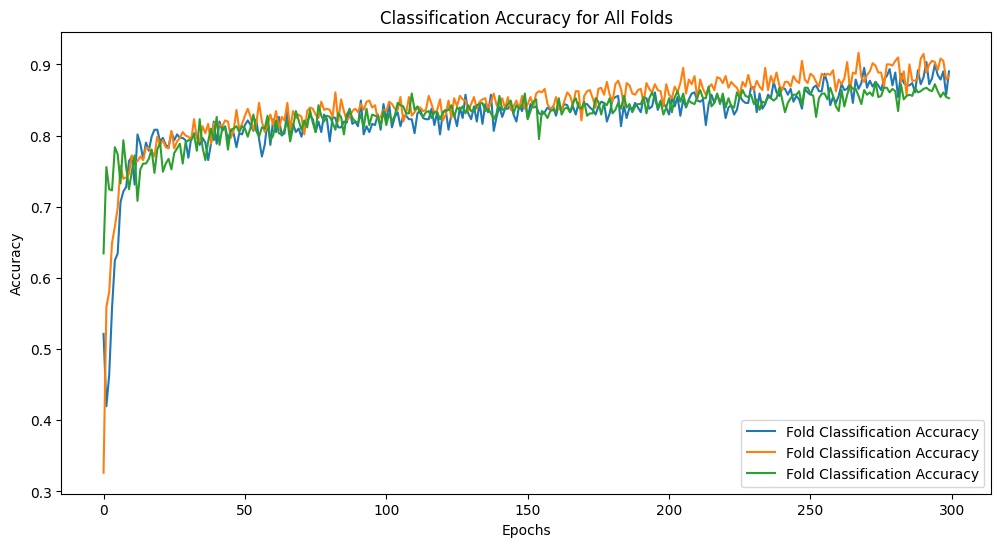

Average Regression Loss: 0.007020725092540185
Average Classification Loss: 0.16462991386651993
Average Regression MSE: 0.0071218679659068584
Average Classification Accuracy: 0.8983606696128845


In [73]:

plt.figure(figsize=(12, 6))
for loss in regression_loss_per_fold:
    plt.plot(loss, label='Fold Regression Loss')
plt.title('Regression Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for loss in classification_loss_per_fold:
    plt.plot(loss, label='Fold Classification Loss')
plt.title('Classification Loss for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ** Regression Accuracy (or MSE) **
plt.figure(figsize=(12, 6))
for mse in regression_mse_per_fold:
    plt.plot(mse, label='Fold Regression MSE')
plt.title('Regression MSE for All Folds')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# ** Classification Accuracy **
plt.figure(figsize=(12, 6))
for acc in classification_accuracy_per_fold:
    plt.plot(acc, label='Fold Classification Accuracy')
plt.title('Classification Accuracy for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

avg_regression_loss = np.mean([np.min(loss) for loss in regression_loss_per_fold])
avg_classification_loss = np.mean([np.min(loss) for loss in classification_loss_per_fold])
avg_regression_mse = np.mean([np.min(mse) for mse in regression_mse_per_fold])
avg_classification_accuracy = np.mean([np.max(acc) for acc in classification_accuracy_per_fold])

print(f'Average Regression Loss: {avg_regression_loss}')
print(f'Average Classification Loss: {avg_classification_loss}')
print(f'Average Regression MSE: {avg_regression_mse}')
print(f'Average Classification Accuracy: {avg_classification_accuracy}')

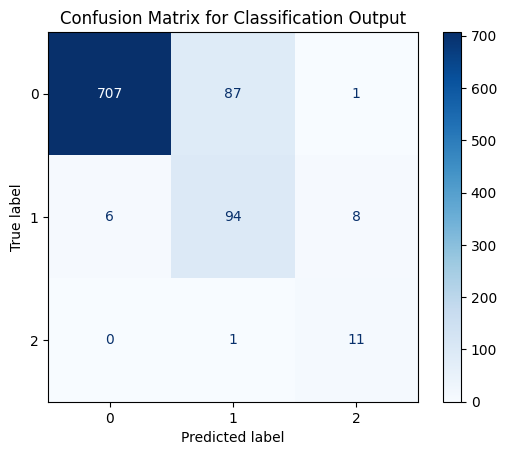

Weighted F1 Score: 0.9002


In [74]:

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(cl_train))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Classification Output')
plt.show()

f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Weighted F1 Score: {f1:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Coefficient de détermination R^2 pour la régression : 0.77


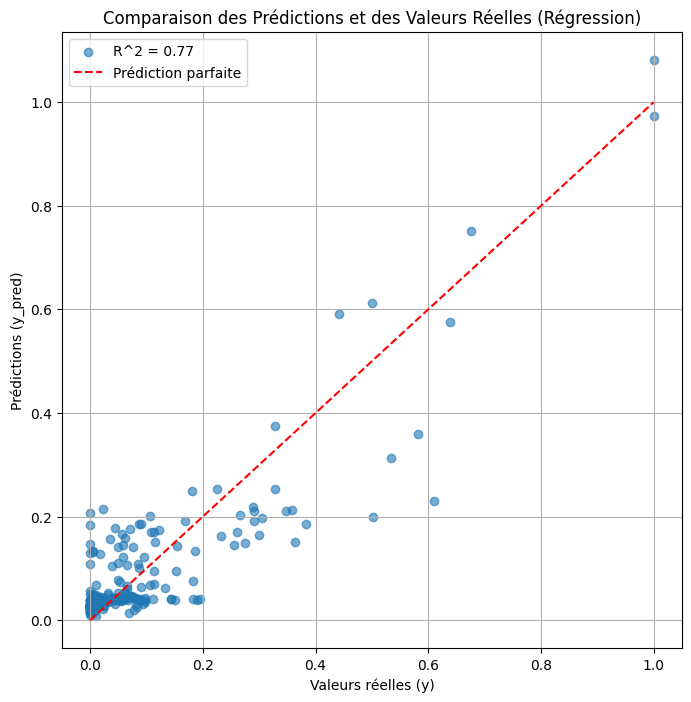

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# After K-Fold cross-validation and training, perform predictions on the test set
# Assuming X_test, y_test, and cl_test are your test set features, regression labels, and classification labels.

# Predict on the test set
regression_preds, classification_preds = model.predict(X_test)

# Compute R^2 for regression
r2 = r2_score(y_test, regression_preds)
print(f"Coefficient de détermination R^2 pour la régression : {r2:.2f}")

# Plot the regression predictions vs. true values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, regression_preds, alpha=0.6, label=f"R^2 = {r2:.2f}")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Prédiction parfaite")
plt.xlabel("Valeurs réelles (y)")
plt.ylabel("Prédictions (y_pred)")
plt.title("Comparaison des Prédictions et des Valeurs Réelles (Régression)")
plt.legend()
plt.grid(True)
plt.show()
